## Cassave Leaf Disease Classification

In [1]:
import torch.nn.functional as F
import torch
from glob import glob
import cv2, random, os
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt

# For pytorch tensor creation
from torch.utils.data import Dataset, DataLoader

## Seperate images into folders by label
import shutil
origin = r'C:\Users\Hedronstone\Desktop\Cassava\data\images'
destination = r'C:\Users\Hedronstone\Desktop\Cassava\cassava_images\train\4'
for i in np.ravel(np.where(train['label'] == 4)).tolist():
    path = origin + f'\\{train["image_id"][i]}'
    shutil.copy(path, destination)

## Load and process dataset

In [2]:
train = pd.read_csv('./data/train.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
from torchvision import datasets, models, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(400),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'./cassava/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                            shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

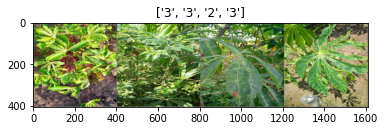

In [4]:
# Visualize a few training images
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0.0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the paramter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) 
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts) 
    
    return model

## Visualize the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetune the model

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Instantiate pretrained ResNet-18 model
model_ft = models.resnet18(pretrained=True)
# Get number of features from fc layer
num_ftrs = model_ft.fc.in_features
# change last layer's outputs from 1000 to 5
model_ft.fc = nn.Linear(num_ftrs, 5)

# Move model to device
model_ft = model_ft.to(device)

# Set loss criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) 

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

In [8]:
# Display model parameters 
for name, param in model_ft.named_parameters():
    print('name:' , name)
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=======')

name: conv1.weight
param.shape:  torch.Size([64, 3, 7, 7])
param.requires_grad:  True
name: bn1.weight
param.shape:  torch.Size([64])
param.requires_grad:  True
name: bn1.bias
param.shape:  torch.Size([64])
param.requires_grad:  True
name: layer1.0.conv1.weight
param.shape:  torch.Size([64, 64, 3, 3])
param.requires_grad:  True
name: layer1.0.bn1.weight
param.shape:  torch.Size([64])
param.requires_grad:  True
name: layer1.0.bn1.bias
param.shape:  torch.Size([64])
param.requires_grad:  True
name: layer1.0.conv2.weight
param.shape:  torch.Size([64, 64, 3, 3])
param.requires_grad:  True
name: layer1.0.bn2.weight
param.shape:  torch.Size([64])
param.requires_grad:  True
name: layer1.0.bn2.bias
param.shape:  torch.Size([64])
param.requires_grad:  True
name: layer1.1.conv1.weight
param.shape:  torch.Size([64, 64, 3, 3])
param.requires_grad:  True
name: layer1.1.bn1.weight
param.shape:  torch.Size([64])
param.requires_grad:  True
name: layer1.1.bn1.bias
param.shape:  torch.Size([64])
param.r

In [9]:
model_ft.summary()

ModuleAttributeError: 'ResNet' object has no attribute 'summary'

In [ ]:
# This cell freezes all parameters, except for the last, 
#  so they will not update during training. Reduces model performance.

for name, param in model_ft.named_parameters():
    if name in ['fc.weight', 'fc.bias']:
        param.requires_grad=True
    else:
        param.requires_grad=False

## Train and evaluate

In [ ]:
import time
import copy

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=31)

In [ ]:
# Save best model
torch.save(model_ft, '.\data\Resnet18_SGD_LRDECAY.pth')

In [ ]:
# Load best model
model_ft = torch.load('.\data\Resnet18_SGD_LRDECAY.pth')

In [ ]:
# Display a few images with their model predictions
visualize_model(model_ft)

## Performance Metrics

## Models (sandbox) 

In [ ]:
# VOneNet: ResNet50 with a primary visual cortex front-end
from vonenet import vonenet
model = vonenet.VOneNet()
model = model.to(device)

In [ ]:
# Display model parameters 
for name, param in model.named_parameters():
    print('name:' , name)
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=======')

In [ ]:
# EfficientNet
import timm
import time
import copy

model = timm.create_model('tf_efficientnet_b3_ns')
n_features = model.classifier.in_features
model.classifier = nn.Linear(n_features, 5) 

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.1)

model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)
